In [1]:
import torch
from time import time
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
from time import time
from torchvision import datasets
from torchvision import transforms
import pandas as pd
import numpy as np
import zipfile
import re
import os
from PIL import Image
from torchvision.io import read_image
from matplotlib import image
from Dataset import MyDataset
from utils import display_some_images,stats_of_image_and_label,MyCuda_Stats,get_output_features_of_model
from vgg_pretrained import vgg,total_parameters

In [4]:
MyCuda_Stats()

No of GPUs i have is 1
0
My Graphic Card is NVIDIA GeForce GTX 1050 Ti
Is Cuda Available True


In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(),normalize])
target_transform=transforms.Compose([transforms.ToTensor()])

In [3]:
anno_dir=r"F:\Affectnet\annotations"
image_dir=r"F:\Affectnet\train_set\train_set\images"
train_data=MyDataset(anno_dir,image_dir,transform=transform, target_transform=None)

In [4]:
val_anno_dir=r"F:\Affectnet\val_set\val_set\annotations"
val_image_dir=r"F:\Affectnet\val_set\val_set\images"
val_data=MyDataset(val_anno_dir,val_image_dir,transform=transform, target_transform=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

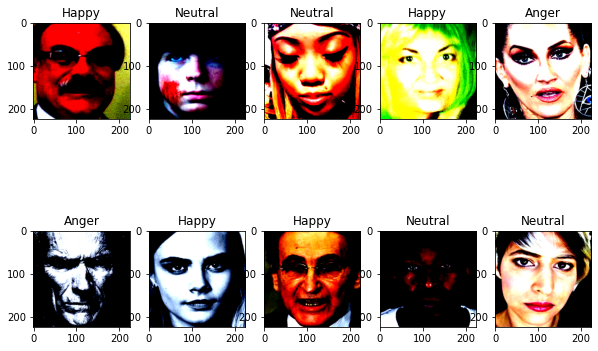

In [7]:
display_some_images(train_data)

In [8]:
a,b=train_data[0]
stats_of_image_and_label(a,b)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.Size([])
torch.float32
torch.float32


In [5]:
train_loader=torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True,num_workers=0)
val_loader=torch.utils.data.DataLoader(val_data,batch_size=32,shuffle=False,num_workers=0)

In [6]:
print(len(train_loader))
print(len(val_loader))

4495
125


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
feature_extractor=vgg()
total_parameters(feature_extractor)


Total 	 7079424


In [ ]:
get_output_features_of_model(model=feature_extractor,batch_size=64,dataloader=train_loader)

In [ ]:
class Network(nn.Module):
  def __init__(self,feature_extractor,input_features_for_denselayer):
    super(Network, self).__init__()
    self.extractor=feature_extractor
    self.RHC=nn.Sequential(
                          nn.Linear(input_features_for_denselayer,4096),
                          nn.Linear(4096,2048),
                          nn.Linear(2048,1024),
                          nn.Linear(1024,128),
                          nn.Linear(128,8))
    self.input_features_for_denselayer=input_features_for_denselayer
    
  def forward(self,x):
    x=self.extractor(x)
    x=x.view(-1,self.input_features_for_denselayer)
    x=self.RHC(x)
    return x
model1=Network(feature_extractor,vgg.classifier[0].in_features).to(device)


In [ ]:
for m1,n1 in train_loader:
    m1,n1=m1,n1
    break
m1.shape
p=model1(m1.to(device))
p.shape

In [ ]:
lr=0.001
loss1=nn.CrossEntropyLoss()
optimizer=optim.SGD(model1.parameters(),lr,momentum=0.9)

In [ ]:
def train(dataloader,model,loss_fn,optimizer):
  model.train()
  for batch,(X,y) in enumerate(train_loader):
    y = y.type(torch.LongTensor)
    X,y=X.to(device),y.to(device)
    pred=model(X)
    #print(pred.dtype,y.dtype)
    #print(pred.get_device(),y.get_device())
    loss=loss_fn(pred,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch%256==0:
      loss=loss.item()
      print(f'loss:{loss:>5f}')

In [ ]:
epochs=10
for epoch in range(epochs):
  print(f'Epoch-{epoch}')
  train(train_loader,model1,loss1,optimizer)
  break